In [1]:
import numpy as np
pos_images = np.load('data/positive_patches.npy')
neg_images = np.load('data/negative_patches.npy')

In [2]:
pos_images.shape, neg_images.shape

((13233, 2914), (30000, 2914))

In [3]:
temp_img = np.reshape(pos_images[0], (62,47))

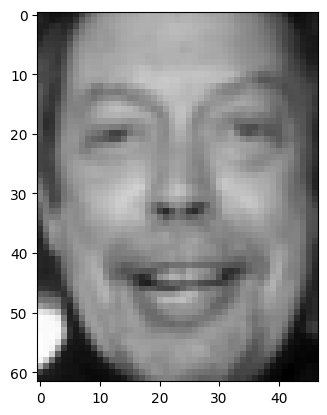

In [4]:
import matplotlib.pyplot as plt
plt.imshow(temp_img, cmap='gray')
plt.show()

In [5]:
# Reshape all images to 62x47 for visualization
# Use list comprehension to optimise perfomance (this does NOT run in parallel, 
# but t's fast than FOR loops because less byte code etc.)
pos_images_reshapes = np.array([np.reshape(img, (62,47)) for img in pos_images])
neg_images_reshapes = np.array([np.reshape(img, (62,47)) for img in neg_images])

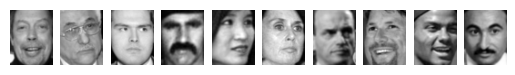

In [6]:
fig, axes = plt.subplots(1, 10)
for i in range(10):
    axes[i].imshow(pos_images_reshapes[i], cmap='gray')
    axes[i].axis('off')
plt.show()

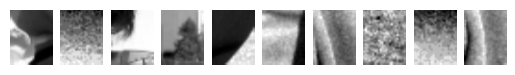

In [7]:
fig, axes = plt.subplots(1, 10)
for i in range(10):
    axes[i].imshow(neg_images_reshapes[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
from skimage import feature
from itertools import chain

# Chaing positive and negative images together = put them into the same list one after the other
# Then compute HOG features for each image in that combined list
# Store results in numpy array (because that's what sklearn wants)

# HOG feature extraction
# For each pixel, compute the Intensity difference between preceding and succeeding pixel in both directions:
#  Gx​=I(x+1,y)−I(x−1,y),Gy​=I(x,y+1)−I(x,y−1)
# Then compute the magnitude and orientation of the gradient vector:
#  magnitude:  M(x,y)=√(Gx​2+Gy​2)
#  orientation:  θ(x,y)=arctan(Gy​/Gx​)
# Then create histograms of gradient orientations for small cells (e.g. 8x8 pixels) in the image
# Each histogram has e.g. 9 bins for different orientation ranges (e.g. 0-20, 20-40, ..., 160-180 degrees)
# Each pixel in the cell votes for one bin in the histogram, weighted by its gradient magnitude.
# This results in a 9 value vector for each cell
# Then group cells into larger blocks (e.g. 2x2 cells, overlapping) chain the histograms of the cells in the block together
# and normalise them to account for changes in illumination/contrast.
# So our 62x47 image with 8x8 cells results in 7x5 cells = 35 cells
# Each cell has a 9 value histogram, so 35*9=315 values per image before block normalisation
# With 2x2 overlapping blocks, we have 6x4 (7-1x5-1)=24 blocks
# Each block has 4 cells with 9 values each, so 24*4*9=864 values per image after block normalisation
# So the final HOG feature vector for each image has 864 values
# However, it could be other values than 8x8 cells and 2x2 blocks, depending on parameters used
X = np.array([
    feature.hog(img)
    for img in chain(pos_images_reshapes, neg_images_reshapes)
])

In [9]:
y = np.zeros(X.shape[0]) # Initialize all to 0 (negative samples)
y[:len(pos_images_reshapes)] = 1  # First len(pos_images_reshapes) are positive samples

In [11]:
# Train test split
from sklearn.model_selection import train_test_split
# Keep same proportion of positive and negative samples in train and test set with stratify=y
# Reproducible results with random_state=42
# 80/20 train/test split with test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from sklearn.svm import SVC
face_detector = SVC()
face_detector.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


Confusion Matrix of face detection:


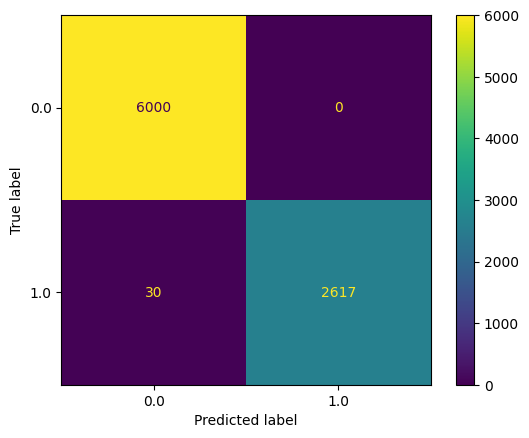

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print("Confusion Matrix of face detection:")
ConfusionMatrixDisplay.from_estimator(face_detector, X_test, y_test)

In [19]:
y_pred = face_detector.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Face', 'Face']))


Classification Report:
              precision    recall  f1-score   support

     No Face       1.00      1.00      1.00      6000
        Face       1.00      0.99      0.99      2647

    accuracy                           1.00      8647
   macro avg       1.00      0.99      1.00      8647
weighted avg       1.00      1.00      1.00      8647

